# miRNA analysis
Ryan Byrne

In [296]:
import pandas as pd
import numpy as np
import math
from scipy import stats
from statsmodels.stats import multitest
import sys,os; sys.path.append(os.environ['BMESAHMETDIR']); import bmes

import sys,os; sys.path.append(os.environ['BMESAHMETDIR']+'/qsb'); from bmes_targetscandb_mir2target import *

# Filter Excel File

In [298]:
#Read File into dataframe
Unfilter_File = pd.read_excel('CRPS_unfiltered.xlsx', index_col=None, header=0)

#Convert dataframe to array
Unfilter_Mat = np.array(Unfilter_File)

#Get size of array
numRows = Unfilter_Mat.shape[0]
numCols = Unfilter_Mat.shape[1]

#Define infinity
inf = float('inf')

#Iterate through each row in array
for i in range(numRows):
    
    #Store number of infinity in row and non infinity numbers
    numInf = 0
    nonInf = []
    
    #If row index contains infinity increase inf counter
    for j in range(1, numCols ):
        if (Unfilter_Mat[i][j] == inf):
            numInf += 1
            
    #If row index contains non infinity store in nonInf array
        else:
            nonInf.append(Unfilter_Mat[i][j])
            
    #If 4 or more entries contain a non infinity value replace every infinity value with the mean of non infinity values
    if (numInf < 58 and numInf > 0):
        average_Exp = np.mean(nonInf)
        line = Unfilter_File.iloc[i, 1:numCols]
        line.loc[line == inf] = average_Exp
        Unfilter_File.iloc[i, 1:numCols] = line
        
    #If the row contains 3 or fewer enteries set control 1 to be infinity to ensure it is removed
    elif (numInf >= 58):
        Unfilter_File.iloc[i, 1] = inf
        
#Remove rows containing infinity and store in filtered dataframe      
Filter_File = Unfilter_File.loc[Unfilter_File["control"] != inf]

#Write data to excel file
Filter_File.to_excel("filtered_Excel_data.xlsx" , index=False)  

# Print the names and fold changes of the top-10 most changing miRNAs (either up or down regulation, i.e., order by descending absolute fold change)

In [299]:
#Read filtered excel file
CRPS_df = pd.read_excel('filtered_Excel_data.xlsx', index_col=None, header=0)

#Create dataframe of snRNA
snRNA_df = CRPS_df[CRPS_df['miRNA'].str.contains('RNU44|RNU48|MammU6', regex=True)]

#Create dataframe of only miRNAs
Non_snRNA_df = CRPS_df[~CRPS_df['miRNA'].str.contains('RNU44|RNU48|MammU6', regex=True)]

#CT0 defined as mean of expression values as mean of miRNAs expression
CT0 = snRNA_df.mean()

#Create dataframe for delCT values
delCT = pd.DataFrame()

#For each row in column find delta CT as difference between expression in the columns CT0 value
for col in CRPS_df.columns:
    if (col != 'miRNA'):
        difference = Non_snRNA_df[col] - CT0[col]
        delCT[col] = difference
    #Set miRNA column in delCT
    else:
        delCT[col] = Non_snRNA_df[col]

#Find number of control groups
columnHeader = list(delCT.columns)
numControl = sum(1 for s in columnHeader if 'control' in s)

#Split delCT by control and patient groups
control = delCT.iloc[: , 1:numControl + 1]

patient = delCT.iloc[: , numControl + 2:]


#Mean of expression for miRNAs in control and patient groups
controlMean = control.mean(axis=1)

patientMean = patient.mean(axis=1)

#Empty data frame for deltadeltaCT values
deldelCT = pd.DataFrame()

#deltadeltaCT values is the difference between mean of patient and control expressions for given miRNA
deldelCT['deltadeltaCT'] = patientMean - controlMean

#Dataframe for storing fold change values
Fold_Change = pd.DataFrame()

#Seting miRNA names to fold change dataframe
Fold_Change['miRNA'] = Non_snRNA_df['miRNA']

#Calculate fold change as 2 to the power of the deltadeltaCT value
Fold_Change['Fold Change'] = 2 ** deldelCT['deltadeltaCT']

#Take negative inverse of fold changes less than one to represent as negative fold change
Fold_Change.loc[(Fold_Change['Fold Change'] < 1), 'Fold Change'] = -1 / Fold_Change['Fold Change'].loc[(Fold_Change['Fold Change'] < 1)]

#Sort fold changes by largest fold change
sorted_Fold_Change = Fold_Change.sort_values(by=['Fold Change'], ascending=False, key=abs)

#Report top 10 highest fold changes
print(sorted_Fold_Change[0:10])

            miRNA  Fold Change
502   hsa-miR-939     5.667763
402   hsa-miR-25#     5.175854
84    hsa-miR-223     4.457306
423   hsa-miR-17#     4.042570
61    hsa-miR-29b     3.721810
275    hsa-let-7c     3.271369
193  hsa-miR-517c     3.266567
21    hsa-miR-18b     3.195216
161    hsa-let-7b     3.156249
6    hsa-miR-133b     3.140113


# Print the names and p-values of the top-10 most significantly different miRNAs (ordered by pvalue)

In [293]:
#Dataframe to store p_vale
p_value = pd.DataFrame()

#Add miRNA names to dataframe
p_value['miRNA'] = Non_snRNA_df['miRNA']

#Total number of miRNAs
numRNA = delCT.shape[0]

#Store p-values
p_stor = []

#For each miRNA perform t-test comparing control and patient groups
for i in range(numRNA):
    
    #perform t-test
    pval = stats.ttest_ind(list(control.iloc[i, :]), list(patient.iloc[i, :]))
    
    #Calculate false discovery rate corrected p-value
    fdr_pval_result = multitest.fdrcorrection(pval.pvalue)
    fdr_pvals = fdr_pval_result[1][0]
    
    #Add p-value to list
    p_stor.append(fdr_pvals)
    
#Update dataframe to contain p values
p_value['p value'] = p_stor

#Sort dataframe by smallest p-value    
sorted_p_value = p_value.sort_values(by=['p value'])

#Report top 10 most signficant p values
print(sorted_p_value[0:10])

              miRNA       p value
275      hsa-let-7c  6.146378e-07
161      hsa-let-7b  7.312196e-07
402     hsa-miR-25#  7.502221e-07
34      hsa-miR-320  9.567768e-07
554    hsa-miR-320B  1.727411e-06
502     hsa-miR-939  2.178983e-06
52      hsa-miR-629  5.032957e-06
96       hsa-let-7d  1.518123e-05
60      hsa-miR-132  2.012160e-05
239  hsa-miR-532-3p  2.550882e-05


# Define p value and fold change thresholds to be used for selecting significantly different miRNAs

In [300]:
#Set p-value threshold as 0.01
p_value_threshold = 0.01

#Set fold change threshold to magnitude of 2.5
fold_change_threshold = 2.5

#Create dataframe for finding most different genes
most_diff_RNA = pd.DataFrame()

#Copy miRNA names
most_diff_RNA['miRNA'] = Non_snRNA_df['miRNA']

#Copy fold changes
most_diff_RNA['Fold Change'] = Fold_Change['Fold Change']

#Copy p-values
most_diff_RNA['p value'] = p_value['p value']

#Filter miRNAs with a fold change greator than threshold
most_diff_RNA = most_diff_RNA.loc[np.absolute(most_diff_RNA['Fold Change']) > fold_change_threshold ]

#Filter miRNAs with a pvalue less than threshold
most_diff_RNA = most_diff_RNA.loc[most_diff_RNA['p value'] < p_value_threshold]

#Store miRNAs that fit critera
sig_miR = list(most_diff_RNA['miRNA'])

# Find Gene Targets from miRNAs

In [302]:
#Store enriched genes
enrichedGenes = []

#For each miRNA in list find target through bmes_targetscandb_mirtarget
#Limit set to 0.98
for miR in sig_miR:
    target = bmes_targetscandb_mir2target(miR,0.98)
    enrichedGenes.extend(target)

#Dataframe for exporting gene list
enrichedGenes_df = pd.DataFrame()

#Add enriched genes to dataframe
enrichedGenes_df['Gene Target'] = enrichedGenes

#Export dataframe to excel
enrichedGenes_df.to_excel("Gene Targets.xlsx" , index=False) 

--- SQL: SELECT distinct("generefseqid") FROM "mir2target" WHERE score>=0.980000 AND mirna IN ("hsa-miR-133b","hsa-miR-133b-3p","hsa-miR-133b-5p")

--- SQL: SELECT distinct("generefseqid") FROM "mir2target" WHERE score>=0.980000 AND mirna IN ("hsa-miR-196b","hsa-miR-196b-3p","hsa-miR-196b-5p")

--- SQL: SELECT distinct("generefseqid") FROM "mir2target" WHERE score>=0.980000 AND mirna IN ("hsa-miR-18b","hsa-miR-18b-3p","hsa-miR-18b-5p")

--- SQL: SELECT distinct("generefseqid") FROM "mir2target" WHERE score>=0.980000 AND mirna IN ("hsa-miR-190","hsa-miR-190-3p","hsa-miR-190-5p")

--- SQL: SELECT distinct("generefseqid") FROM "mir2target" WHERE score>=0.980000 AND mirna IN ("hsa-miR-29b","hsa-miR-29b-3p","hsa-miR-29b-5p")

--- SQL: SELECT distinct("generefseqid") FROM "mir2target" WHERE score>=0.980000 AND mirna IN ("hsa-let-7a","hsa-let-7a-3p","hsa-let-7a-5p")

--- SQL: SELECT distinct("generefseqid") FROM "mir2target" WHERE score>=0.980000 AND mirna IN ("hsa-miR-20a","hsa-miR-20a-3p","

# Top 3 most significantly enriched pathways

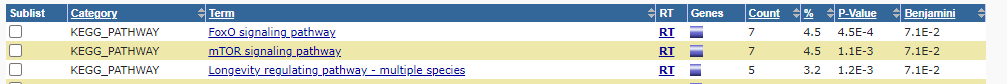

# Top 3 most significantly enriched Gene Ontology terms

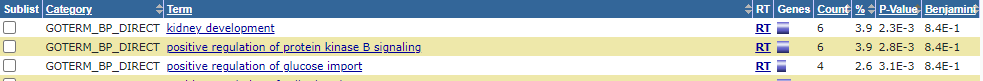